## Transfer Learning
dataset : https://www.kaggle.com/datasets/salader/dogs-vs-cats

- Login to kaggle.com
- Goto https://www.kaggle.com/settings
- Create new token
- it will diwnload your API key (keep it private)

create a directory kaggle in home directory and copy a file named kaggle.json into it.

In [3]:
# Install the Kaggle API
!pip install -q kaggle

# Upload your Kaggle API key file (kaggle.json) using the file picker that appears after running this cell.
from google.colab import files
files.upload()

# Move the uploaded Kaggle API key file to the appropriate directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d salader/dogs-vs-cats


Saving kaggle.json to kaggle.json
100% 1.06G/1.06G [00:28<00:00, 42.1MB/s]
100% 1.06G/1.06G [00:28<00:00, 40.6MB/s]


## Extract files

In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [9]:
!ls -l

total 1116132
drwxr-xr-x 4 root root       4096 Mar 19 16:40 dogs_vs_cats
-rw-r--r-- 1 root root 1142891694 Oct 13  2019 dogs-vs-cats.zip
-rw-r--r-- 1 root root         68 Mar 19 16:37 kaggle.json
drwxr-xr-x 1 root root       4096 Mar 15 13:25 sample_data
drwxr-xr-x 4 root root       4096 Mar 19 16:40 test
drwxr-xr-x 4 root root       4096 Mar 19 16:40 train


In [19]:
ls -al

total 1116144
drwxr-xr-x 1 root root       4096 Mar 19 16:51 ./
drwxr-xr-x 1 root root       4096 Mar 19 16:18 ../
drwxr-xr-x 4 root root       4096 Mar 15 13:25 .config/
drwxr-xr-x 4 root root       4096 Mar 19 16:40 dogs_vs_cats/
-rw-r--r-- 1 root root 1142891694 Oct 13  2019 dogs-vs-cats.zip
-rw-r--r-- 1 root root         68 Mar 19 16:37 kaggle.json
drwxr-xr-x 1 root root       4096 Mar 15 13:25 sample_data/
drwxr-xr-x 4 root root       4096 Mar 19 16:40 test/
drwxr-xr-x 4 root root       4096 Mar 19 16:40 train/


In [20]:
#import libraries
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16


- Imports the VGG16 convolutional base from the Keras library  
- configures it with weights, input_shape, and include_topparameters:


In [21]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

58889256/58889256 [==============================] - 2s 0us/step


In [22]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

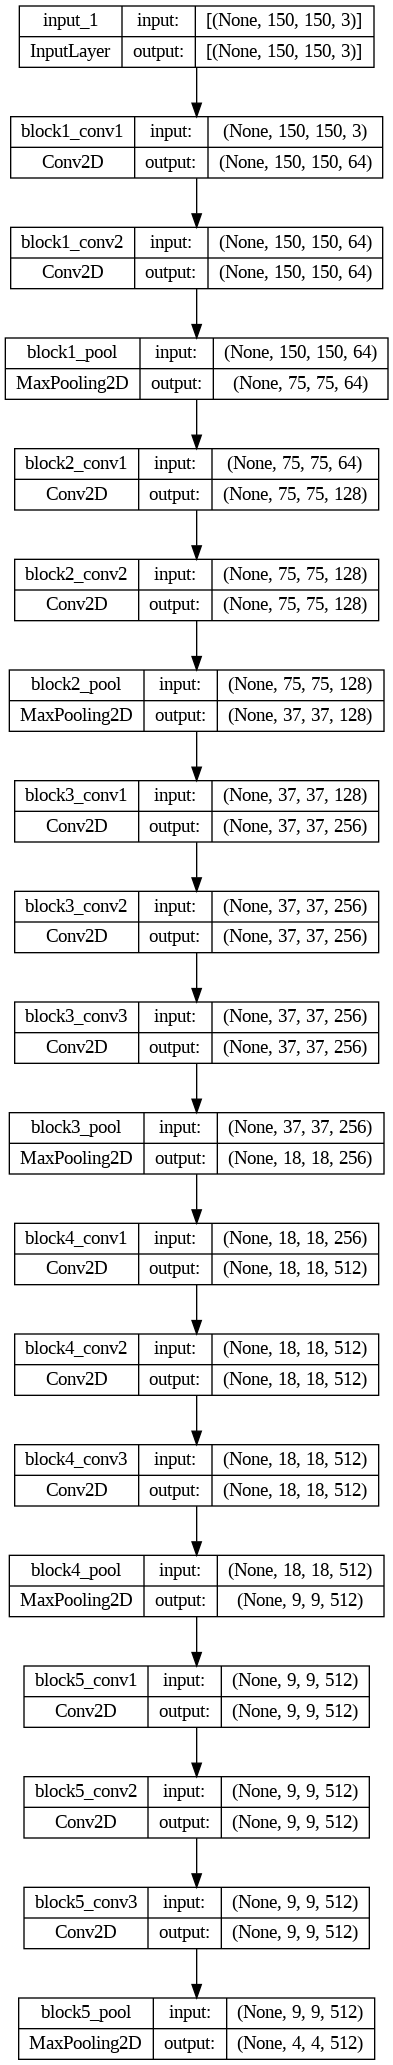

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(conv_base, to_file='vgg16_conv_base.png', show_shapes=True)

In [25]:
model = Sequential()

model.add(conv_base) # adds conv_base model for transfer learning
# flattens the output of the convolutional base into a 1D array,
# preparing it for input into the fully connected layers.
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


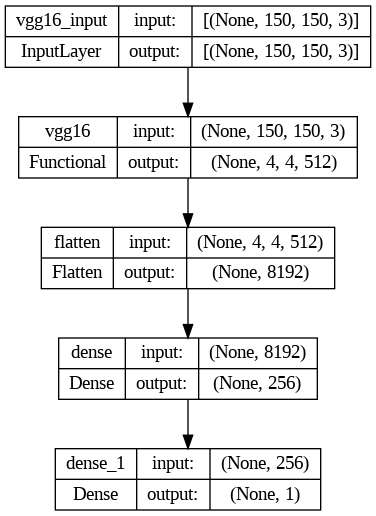

In [27]:
plot_model(model, to_file='model.png', show_shapes=True)

- freeze the convolutional base of the VGG16 model
- its weights will not be updated during training when we later attach additional layers to it.
- it helps transfer learning to use the pre-trained base model as a fixed feature extractor
- it will only train the newly added fully connected layers on the dataset.
- it helps to prevent the pre-trained weights from being modified
- preserves the knowledge learned from the original dataset (ImageNet)
- leads to better performance,  when a limited  data available for fine-tuning.

In [28]:
conv_base.trainable = False

-create image datasets for training and validation using images inside directories whuch contain cats and dog images

In [30]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


normalizes the image data to ensure the pixel values are within a consistent range,

In [31]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [32]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [33]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [34]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 71s 102ms/step - loss: 0.2659 - accuracy: 0.8852 - val_loss: 0.2589 - val_accuracy: 0.8882
Epoch 2/10
625/625 [==============================] - 54s 86ms/step - loss: 0.1977 - accuracy: 0.9158 - val_loss: 0.2054 - val_accuracy: 0.9104
Epoch 3/10
625/625 [==============================] - 64s 103ms/step - loss: 0.1607 - accuracy: 0.9341 - val_loss: 0.2055 - val_accuracy: 0.9154
Epoch 4/10
625/625 [==============================] - 64s 103ms/step - loss: 0.1312 - accuracy: 0.9463 - val_loss: 0.2669 - val_accuracy: 0.8864
Epoch 5/10
625/625 [==============================] - 55s 87ms/step - loss: 0.1024 - accuracy: 0.9597 - val_loss: 0.2467 - val_accuracy: 0.9002
Epoch 6/10
625/625 [==============================] - 64s 103ms/step - loss: 0.0840 - accuracy: 0.9669 - val_loss: 0.2379 - val_accuracy: 0.9072
Epoch 7/10
625/625 [==============================] - 65s 103ms/step - loss: 0.0583 - accuracy: 0.9783 - val_loss: 0.2998 - val_accu

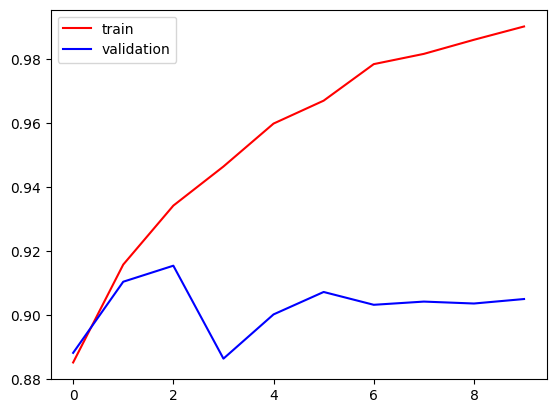

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

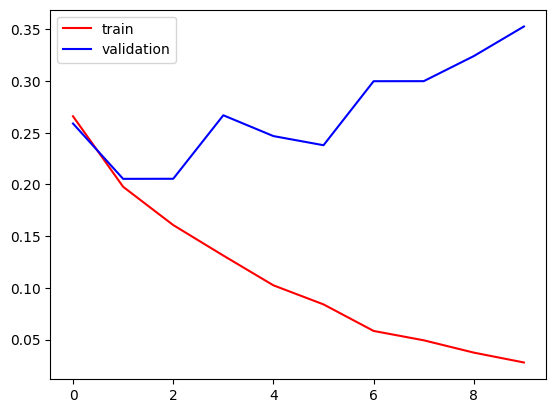

In [36]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

## more
https://colab.research.google.com/drive/1q_INiVDAzhSy1L_A87fBTf2wC3l3MiWy?usp=sharing

https://colab.research.google.com/drive/1mEWfubs2tR0CkqyxqP49cK30n7V5_NCm?usp=sharing